# Chelan 4: Affected area analysis

Jason MacDonald  
UW Geospatial Data Analysis  
CEWA567 - Winter 2023  
credit to: David Shean, for instruction, guidance, and starter code  
credit to: Eric Gagliano, for additional guidance and starter code  

[Chelan_0 Query Data](./chelan_0_query-data_2021.ipynb) << RUN THIS FIRST  
[Chelan_1 Site Exploration](./chelan_1_site-exploration.ipynb)  
[Chelan_2 RGB Analysis](./chelan_2_rgb-analysis.ipynb)   
[Chelan_3 Timeseries Visualization](./chelan_3_timeseries-visualization.ipynb)  
[Chelan_4 Affected Area Analysis](./chelan_4_affected-area-analysis.ipynb)

## Access images

In [1]:
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
from datetime import datetime

In [2]:
import rasterio as rio
import rasterio.windows
import rasterio.plot
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [3]:
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar
#for titles
from textwrap import wrap
#for legends
import matplotlib.patches as mpatches

In [4]:
!pip install earthaccess

In [5]:
import earthaccess

auth = earthaccess.login(strategy="netrc")
if not auth:
    auth = earthaccess.login(strategy="interactive", persist=True)
# run single line below if first time
#auth = earthaccess.login(strategy="interactive", persist=True)

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 05/10/2023
Using .netrc file for EDL


## Rasterio window
* Instead of array indexing, we can use the built-in `rasterio.windows.Window` functionality
    * This is really valuable when you only want to load a small portion of a large dataset that is too big to fit into available RAM
        * With array indexing, we must load the entire array into memory and then extract the desired window
        * With the rasterio window, we never have to load the full array
    * https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
    * Syntax is `rasterio.windows.Window(col_offset, row_offset, width, height)`

In [6]:
# Set our rasterio window about Lake Chelan
# choose this now, so we can include it in our output folder
# used iteration find area of interest

#Lake Chelan
#window = rasterio.windows.Window(1750, 1000, 2048, 2048)
#window = rasterio.windows.Window(2400, 1500, 512, 1024)
window_id = 'northwest'
window = rasterio.windows.Window(2400, 1500, 1024, 1024)
#window = rasterio.windows.Window(2400, 1500, 2048, 2048) #error

#window = rasterio.windows.Window(2250, 1500, 512, 512)

In [7]:
#Set up directory for output
notebook = 'chelan_4_affected-area-analysis'
path = './output/%s/%s' %(notebook, window_id) #relative path
#path = '/home/jovyan/project/chelanigans/output/%s' %notebook #absolute path
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)

In [8]:
#access gdf output from query notebook
path = './output/chelan_0_query-data_2021/gf_lesscloud_20_sentinel.geoJSON' #relative path
#path = '/home/jovyan/project/chelanigans/output/chelan_0_query-data_2021/gf_lesscloud_20_sentinel.geoJSON' #absolute path
gf_lesscloud_20_sentinel = gpd.read_file(path)
gf_lesscloud_20_sentinel_df = pd.DataFrame(gf_lesscloud_20_sentinel, columns=('eo:cloud_cover', 'stac_id', 'time', 'platform'))
gf_lesscloud_20_sentinel_df

,eo:cloud_cover,stac_id,time,platform
0,5,HLS.S30.T10UFU.2021062T190301.v2.0,2021-03-03 19:11:08.571000+00:00,S
1,16,HLS.S30.T10UFU.2021092T185921.v2.0,2021-04-02 19:11:05.535000+00:00,S
2,0,HLS.S30.T10UFU.2021107T185909.v2.0,2021-04-17 19:11:04.007000+00:00,S
3,9,HLS.S30.T10UFU.2021142T185921.v2.0,2021-05-22 19:11:09.221000+00:00,S
4,0,HLS.S30.T10UFU.2021152T185921.v2.0,2021-06-01 19:11:09.530000+00:00,S
5,1,HLS.S30.T10UFU.2021172T185921.v2.0,2021-06-21 19:11:09.531000+00:00,S
6,0,HLS.S30.T10UFU.2021177T185919.v2.0,2021-06-26 19:11:09.416000+00:00,S
7,4,HLS.S30.T10UFU.2021187T185919.v2.0,2021-07-06 19:11:10.358000+00:00,S
8,1,HLS.S30.T10UFU.2021192T185921.v2.0,2021-07-11 19:11:11.712000+00:00,S
9,10,HLS.S30.T10UFU.2021207T185919.v2.0,2021-07-26 19:11:10.637000+00:00,S


## PNW 2021 heatwave dates: June 26 - July 2

In [9]:
#for ease of access to stac_id and date

gdf = gf_lesscloud_20_sentinel   
#for cloud, stac_id, time in gdf:
img_list = [stac_id for stac_id in gdf['stac_id']]
date_list = [time.date().strftime('%Y-%m-%d') for time in gdf['time']]
print(date_list, img_list)

['2021-03-03', '2021-04-02', '2021-04-17', '2021-05-22', '2021-06-01', '2021-06-21', '2021-06-26', '2021-07-06', '2021-07-11', '2021-07-26', '2021-09-24'] ['HLS.S30.T10UFU.2021062T190301.v2.0', 'HLS.S30.T10UFU.2021092T185921.v2.0', 'HLS.S30.T10UFU.2021107T185909.v2.0', 'HLS.S30.T10UFU.2021142T185921.v2.0', 'HLS.S30.T10UFU.2021152T185921.v2.0', 'HLS.S30.T10UFU.2021172T185921.v2.0', 'HLS.S30.T10UFU.2021177T185919.v2.0', 'HLS.S30.T10UFU.2021187T185919.v2.0', 'HLS.S30.T10UFU.2021192T185921.v2.0', 'HLS.S30.T10UFU.2021207T185919.v2.0', 'HLS.S30.T10UFU.2021267T190029.v2.0']


In [10]:
#for use with looping through rasters later
# this may not be the best way, stick with above
#gdf = gf_lesscloud_20_sentinel
#date = gdf.time.items()
#img = gdf.stac_id.items()
#date_img = zip(date, img)   
#for d, i in date_img:
#    date = d[1].date()
#    img = i[1]
#    print(date, img)

In [11]:
#Set path to local directory with downloaded images
imgdir = '/home/jovyan/project/chelanigans/data'

In [12]:
#Define image to use (can set this to switch to pre/post heatwave image
img = img_list[-1]
date = date_list[-1]

In [13]:
#Specify filenames for different bands

r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

In [14]:
#Sentinel-2
base_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020'
#full_url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021362T190811.v2.0/HLS.S30.T10UFU.2021362T190811.v2.0.B02.tif'

#img_list = (img_id2, img_id1)
band_list = ('02', '03', '04', '08','11') 

#Loop through all selected images and bands
#for img in img_list:
for img in img_list:
    for b in band_list:
        #Generate the appropriate URL for the images we identified
        image_url =  '{0}/{1}/{1}.B{2}.tif'.format(base_url, img, b)    
        print(image_url)
    #Local filename
        out_fn = os.path.join(imgdir, os.path.split(image_url)[-1])
    #Check to see if file already exists
        if not os.path.exists(out_fn):
            print("Saving:", out_fn)
        
        #Download the file
        #figure out authorization here
            #urllib.request.urlretrieve(image_url, out_fn)

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B02.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B03.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B04.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B08.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021062T190301.v2.0/HLS.S30.T10UFU.2021062T190301.v2.0.B11.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.2021092T185921.v2.0/HLS.S30.T10UFU.2021092T185921.v2.0.B02.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T10UFU.202109

In [15]:
#Sanity check
#Leave these Datasets open for use later in lab (e.g., extracting resolution)
r_src = rio.open(r_fn)
print("MS", r_src.profile)

MS {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_wkt('PROJCS["UTM Zone 10, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not specified (based on WGS 84 spheroid)",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 600000.0,
       0.0, -30.0, 5400000.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


In [16]:
#NOTE: replaced p_src (opened pancromatic band file) with r_src (red) for the bounds input below
# no pan with Sentinel
# not sure if this is the best solution

#Define window bounds for Pan 
window_bounds = rasterio.windows.bounds(window, r_src.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (672000.0, 5324280.0, 702720.0, 5355000.0)
Window extent:  [672000.0, 702720.0, 5324280.0, 5355000.0]


### Function to read only this subwindow into an array

In [17]:
def rio2ma(fn, b=1, window=None, scale=True):
    with rio.open(fn) as src:
        #Read in the window to masked array
        a = src.read(b, window=window, masked=True)
        #If Level 2 surface reflectance and surface temperature, scale values appropriately
        #not needed for this project
        if scale:
            if 'SR' in fn:
                #Output in unitless surface reflectance from 0-1
                a = a * sr_scale + sr_offset
            elif 'ST' in fn:
                #Output in degrees Celsius
                a = a * st_scale + st_offset - 273.15
            a = a.astype('float32')
        return a

### Function to normalize (AKA contrast stretch) input image array values
* The input image pixel values are `UInt16` (unsigned, 16-bit integer, spanning the range 0-65535)
* We want to rescale to `float` values over the range (0.0-1.0)

In [18]:
def normie(data, low_perc, up_perc):
    perc = np.percentile(data.compressed(), (low_perc, up_perc)) #default (2, 98)
    normd = (data - perc[0])/(perc[1] - perc[0])
    clipd = np.clip(normd, 0, 1)
    return clipd

## Clip data to Lake Chelan polygon

In [19]:
#wa_lakes_gjson_url = '#https://geo.wa.gov/datasets/WSDOT::wsdot-major-lakes-1500k/explore?filters=eyJOQU1FIjpbIkxha2UgQ2hlbGFuIl19&location=48.085597%2C-120.767080%2C9.89'
wa_lakes_gjson_url = '/home/jovyan/project/chelanigans/data/WSDOT_-_Major_Lakes_(1%3A500K).geojson'
wa_lakes_gjson_gdf = gpd.read_file(wa_lakes_gjson_url) #just pointing to downloaded file for now
#Reproject to match raster
wa_lakes_gjson_gdf_proj = wa_lakes_gjson_gdf.to_crs(r_src.crs)
#Isolate Lake Chelan
chelan_gjson_iso = wa_lakes_gjson_gdf_proj.loc[wa_lakes_gjson_gdf_proj['NAME'] == 'Lake Chelan']
#Extract geometry to use for clipping
chelan_geom = chelan_gjson_iso.iloc[0].geometry

In [20]:
#Pass this in to the `rio.mask.mask` call (see demo)
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
#must pass chelan_geom polygon as list because rio.mask.mask expects multipolygon
chelan_mask, chelan_mask_transform = rio.mask.mask(r_src, [chelan_geom,], **rio_mask_kwargs)

In [21]:
#Get clipped extent in UTM coordinates
chelan_mask_extent = rio.plot.plotting_extent(chelan_mask, chelan_mask_transform)
chelan_mask_extent

(672150.0, 709800.0, 5302170.0, 5354820.0)

## IMPOTANT: Match mask extents to project window
#### trim Lake Chelan mask using index slicing to match the project window

In [22]:
#trim Lake Chelan mask using index slicing to match the project window

#ndti_masked = ma.masked_where(chelan_mask==True, ndti)
chelan_mask_trim = chelan_mask[ 0:window.height , 0:window.width]
chelan_mask_trim.shape

(1024, 1024)

## Raster Classification Using Threshold
### Create binary NDTI and NDSSI masks
* Need to define a cutoff value (threshold) for NDVI values to define a boolean vegetation mask
    * NDTI/NDSSI values above this threshold will be classified as "turbidity" and "ss" respectively
    * NDTI/NDSSI values below this threshold will be classified as "not turbidity" and "not ss" respectively
* To decide on a threshold, plot a histogram of NDTI/NDSSI values

In [23]:
#set thresh based on histogram below
thresh_ndti = -0.35
thresh_ndssi = 0.1

In [24]:
#%matplotlib widget

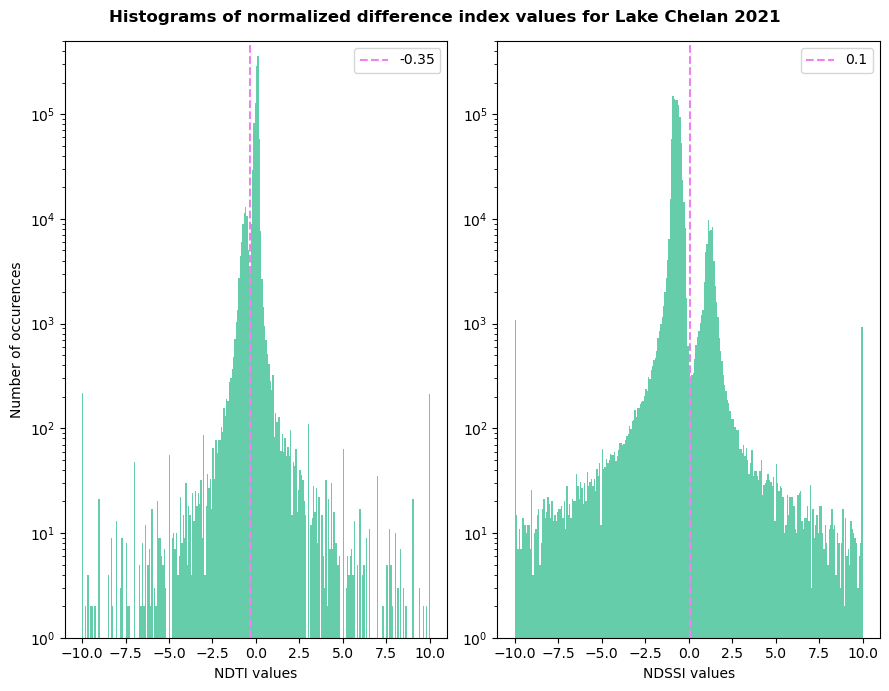

In [25]:
#Specify filenames for different bands
r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

# load window from red, green, blue tif files
r = rio2ma(r_fn, b=1, window=window, scale=True)
g = rio2ma(g_fn, b=1, window=window, scale=True)
b = rio2ma(b_fn, b=1, window=window, scale=True)
nir = rio2ma(nir_fn, b=1, window=window, scale=True)
 
#set our index variables for 
#normalized difference turbidity index
ndti = (r - g) / (r + g)
#normalized difference suspended solids index
ndssi = (b - nir) / (b + nir)

#clip
ndti = np.ma.clip(ndti, -10, 10)
ndssi = np.ma.clip(ndssi, -10, 10)

fig, axa = plt.subplots(1,2, figsize=(9,7))
fig.suptitle('Histograms of normalized difference index values for Lake Chelan %s' %date[0:4],
             fontsize=12,
             fontweight='bold',
             y=.98)   

axa[0].hist(ndti.compressed().ravel(), bins=256, color='mediumaquamarine', log=True)

axa[0].axvline(thresh_ndti, ls='--', c='violet', label=thresh_ndti)
axa[0].set_ylim(1,500000)

axa[0].legend()
axa[0].set_ylabel('Number of occurences')
axa[0].set_xlabel('NDTI values')

axa[1].hist(ndssi.compressed().ravel(), bins=256, color='mediumaquamarine', log=True)

axa[1].axvline(thresh_ndssi, ls='--', c='violet', label=thresh_ndssi)
axa[1].set_ylim(1,500000)

axa[1].legend()
axa[1].set_xlabel('NDSSI values')
plt.tight_layout();

For a more clear approach,  
let's try that with normalization of rgb bands before index math

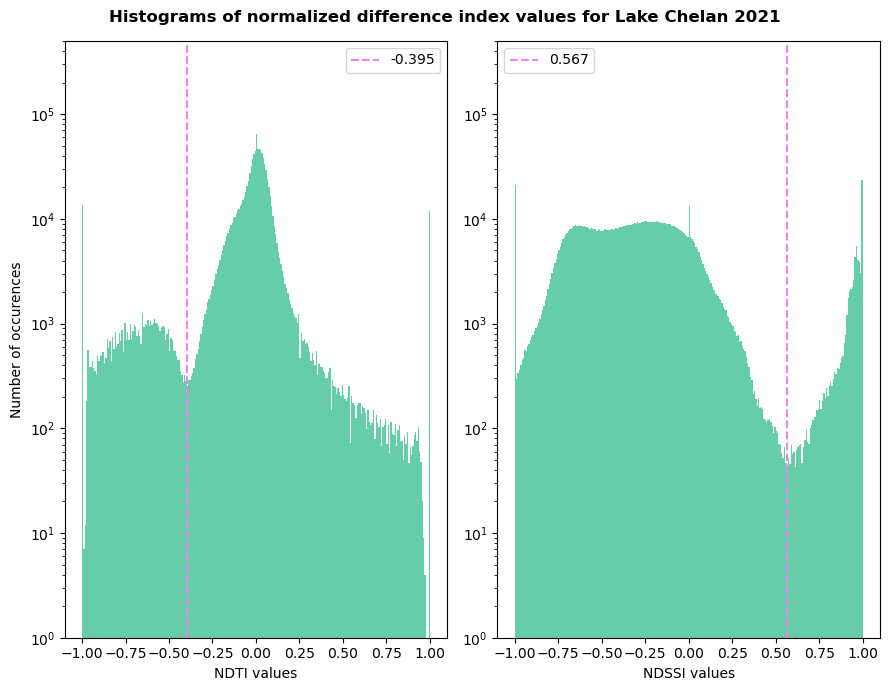

In [26]:

#set thresh based on histogram below
thresh_ndti = -0.395
thresh_ndssi = 0.567

#Specify filenames for different bands
r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

# load window from red, green, blue tif files
r = rio2ma(r_fn, b=1, window=window, scale=True)
g = rio2ma(g_fn, b=1, window=window, scale=True)
b = rio2ma(b_fn, b=1, window=window, scale=True)
nir = rio2ma(nir_fn, b=1, window=window, scale=True)

r_normd = normie(r, 2, 98)
g_normd = normie(g, 2, 98)
b_normd = normie(b, 2, 98)
nir_normd = normie(nir, 2, 98)

#set our index variables for 
#normalized difference turbidity index
ndti = (r_normd - g_normd) / (r_normd + g_normd)
#normalized difference suspended solids index
ndssi = (b_normd - nir_normd) / (b_normd + nir_normd)

#clip
ndti = np.ma.clip(ndti, -10, 10)
ndssi = np.ma.clip(ndssi, -10, 10)

fig, axa = plt.subplots(1,2, figsize=(9,7))
fig.suptitle('Histograms of normalized difference index values for Lake Chelan %s' %date[0:4],
             fontsize=12,
             fontweight='bold',
             y=.98)   

axa[0].hist(ndti.compressed().ravel(), bins=256, color='mediumaquamarine', log=True)

axa[0].axvline(thresh_ndti, ls='--', c='violet', label=thresh_ndti)
axa[0].set_ylim(1,500000)

axa[0].legend()
axa[0].set_ylabel('Number of occurences')
axa[0].set_xlabel('NDTI values')

axa[1].hist(ndssi.compressed().ravel(), bins=256, color='mediumaquamarine', log=True)

axa[1].axvline(thresh_ndssi, ls='--', c='violet', label=thresh_ndssi)
axa[1].set_ylim(1,500000)

axa[1].legend()
axa[1].set_xlabel('NDSSI values')
plt.tight_layout();

Much better! I should be able to adopt a program that will detect the depression.

In [27]:
# create dataframe to store timeseries analysis
chelan_df = []
NDTI_area_ls = []
NDSSI_area_ls = []

chelan_df = pd.DataFrame(date_list[::])
chelan_df.rename({0:'date'}, axis=1, inplace=True)
#chelan_df['img'] = img_list[::]
chelan_df['img'] = img_list[::]

#chelan_df = img_list.append(date_list)
chelan_df.head()

,date,img
0,2021-03-03,HLS.S30.T10UFU.2021062T190301.v2.0
1,2021-04-02,HLS.S30.T10UFU.2021092T185921.v2.0
2,2021-04-17,HLS.S30.T10UFU.2021107T185909.v2.0
3,2021-05-22,HLS.S30.T10UFU.2021142T185921.v2.0
4,2021-06-01,HLS.S30.T10UFU.2021152T185921.v2.0


In [28]:
%matplotlib inline

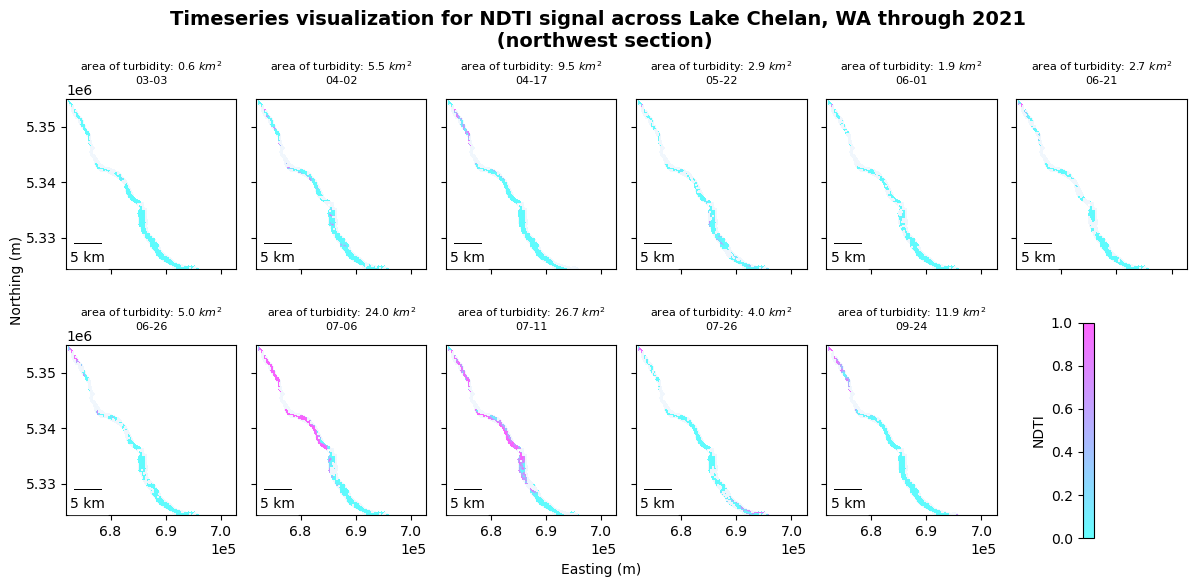

In [29]:
fig, axa = plt.subplots(2, 6, figsize=(12, 6), edgecolor='k', sharex=True, sharey=True)
#plt.figure(figsize=(18, 12), edgecolor='k')
fig.subplots_adjust(hspace = .15, wspace=.5)
fig.suptitle('Timeseries visualization for NDTI signal across Lake Chelan, WA through %s \n (%s section)' %(date[0:4], window_id),
             fontsize=14,
             fontweight='bold',
             y=.95)    

axa = axa.ravel()

for i in enumerate(img_list[0:11]):
    img = str(i[1])
    index = (i[0])
    date = str(date_list[index])

    #Specify filenames for different bands
    r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
    g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
    swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

        # load window from red, green, blue tif files
    r = rio2ma(r_fn, b=1, window=window, scale=True)
    g = rio2ma(g_fn, b=1, window=window, scale=True)
    #b = rio2ma(b_fn, b=1, window=window, scale=True)
    #nir = rio2ma(nir_fn, b=1, window=window, scale=True)
    
    r_masked = ma.masked_where(chelan_mask_trim==True,r)
    g_masked = ma.masked_where(chelan_mask_trim==True,g)
    
    r_masked_norm = normie(r_masked, 2, 98)
    g_masked_norm = normie(g_masked, 2, 98)
    
    #set our index variables for 
    #normalized difference turbidity index
    ndti = (r_masked_norm - g_masked_norm) / (r_masked_norm + g_masked_norm)
    #normalized difference suspended solids index
    #ndssi = (b - nir) / (b + nir)

    #clip
    ndti_clipd = np.ma.clip(ndti, -10, 10)
    #ndssi = np.ma.clip(ndssi, -1, 1)
    
    ndti_clipd_thresh_mask = ndti_clipd<=thresh_ndti
    
    truths = ndti_clipd_thresh_mask.sum()
    turb = truths * 0.03 * 0.03
    area_of_turb = ('area of turbidity: %.1f $km^2$' %turb)
    NDTI_area_ls.append(round(turb,2))
    
    #plot NDTI
    axa[index].imshow(chelan_mask, extent=chelan_mask_extent, cmap='Blues')
    shw0 = axa[index].imshow(ndti_clipd_thresh_mask, cmap='cool', extent=window_extent, alpha=0.6, vmin=0, vmax=1)
    
    axa[index].add_artist(ScaleBar(1.0, location='lower left'))
    axa[index].set_title(area_of_turb+'\n'+date[5:10], fontsize=8, y=1.04)
    axa[index].ticklabel_format(scilimits=(1,3))
    axa[index].set_xlim(window_extent[0], window_extent[1])
    axa[index].set_ylim(window_extent[2], window_extent[3])    
    
    plt.tight_layout()

fig.text(0.5, 0.01, 'Easting (m)', ha='center')
fig.text(0.007, 0.5, 'Northing (m)', va='center', rotation='vertical')
#https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
    
fig.delaxes(axa[-1])
bar = plt.colorbar(shw0, ax=axa[-1], location='left', anchor=(4.5,0.5), shrink=0.9, label="NDTI")
plt.tight_layout()

chelan_df['NDTI_area'] = NDTI_area_ls[::]

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/%s/NDTI_thresh_timeseries.png' %(notebook, window_id))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

In [30]:
%matplotlib widget


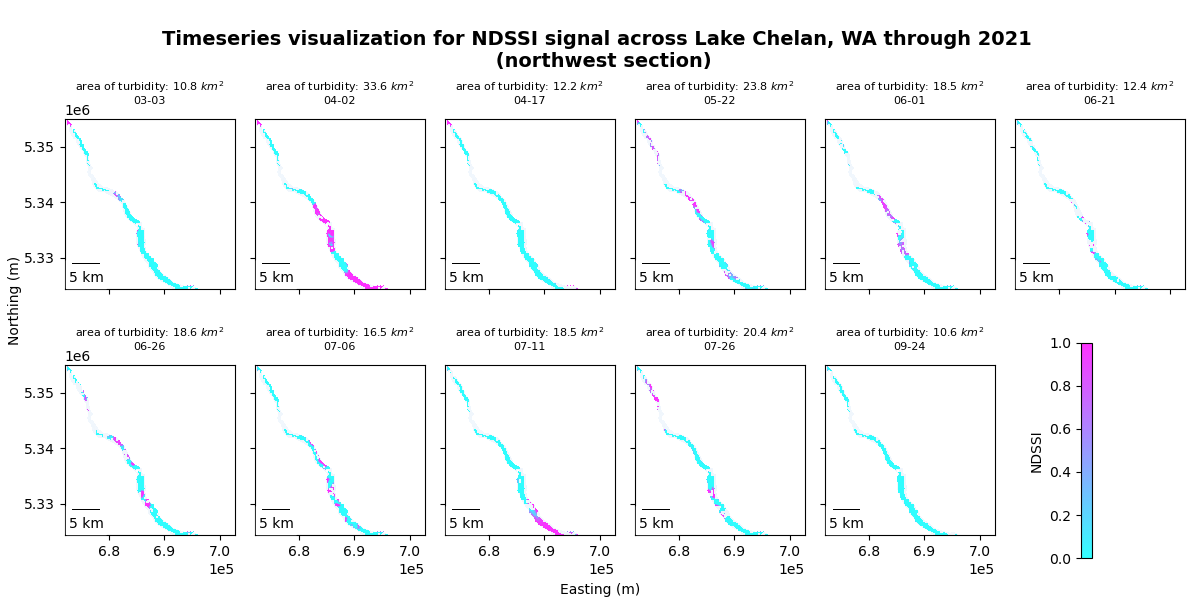

In [31]:
fig, axa = plt.subplots(2, 6, figsize=(12, 6), edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .15, wspace=.5)
fig.suptitle('Timeseries visualization for NDSSI signal across Lake Chelan, WA through %s \n (%s section)' %(date[0:4], window_id),
             fontsize=14,
             fontweight='bold',
             y=.95)    

axa = axa.ravel()

for i in enumerate(img_list[0:11]):
    img = str(i[1])
    index = (i[0])
    date = str(date_list[index])

    #Specify filenames for different bands
    #r_fn = os.path.join(imgdir, img+'.B04.tif') #Red
    #g_fn = os.path.join(imgdir, img+'.B03.tif') #Green
    b_fn = os.path.join(imgdir, img+'.B02.tif') #Blue
    nir_fn = os.path.join(imgdir, img+'.B08.tif') #Near-Infrared (NIR08)
    #swir_fn = os.path.join(imgdir, img+'.B11.tif') #Shortwave-Infrared (SWIR16)

        # load window from red, green, blue tif files
    #r = rio2ma(r_fn, b=1, window=window, scale=True)
    #g = rio2ma(g_fn, b=1, window=window, scale=True)
    b = rio2ma(b_fn, b=1, window=window, scale=True)
    nir = rio2ma(nir_fn, b=1, window=window, scale=True)
    
        
    b_masked = ma.masked_where(chelan_mask_trim==True,b)
    nir_masked = ma.masked_where(chelan_mask_trim==True,nir)
    
    b_masked_norm = normie(b_masked, 2, 98)
    nir_masked_norm = normie(nir_masked, 2, 98)
    
    #set our index variables for 
    #normalized difference turbidity index
    #ndti = (r - g) / (r + g)
    #normalized difference suspended solids index
    ndssi = (b_masked_norm - nir_masked_norm) / (b_masked_norm + nir_masked_norm)

    #clip
    #ndti = np.ma.clip(ndti, -1, 0)
    ndssi = np.ma.clip(ndssi, -1, 1)
    
    ndti_chelan = ndti<=thresh_ndti
    ndssi_chelan = ndssi<=thresh_ndssi
    
    truths = ndssi_chelan.sum()
    turb = truths * 0.03 * 0.03
    area_of_turb = ('area of turbidity: %.1f $km^2$' %turb)
    NDSSI_area_ls.append(round(turb,2))
    
    #plot NDTI
    axa[index].imshow(chelan_mask, extent=chelan_mask_extent, cmap='Blues')
    shw0 = axa[index].imshow(ndssi_chelan, extent=window_extent, cmap='cool', alpha=0.8, vmin=0, vmax=1)
    
    axa[index].add_artist(ScaleBar(1.0, location='lower left'))
    axa[index].set_title(area_of_turb+'\n'+date[5:10], fontsize=8, y=1.04)
    axa[index].ticklabel_format(scilimits=(1,3))
    axa[index].set_xlim(window_extent[0], window_extent[1])
    axa[index].set_ylim(window_extent[2], window_extent[3])    
    
    plt.tight_layout()

fig.text(0.5, 0.01, 'Easting (m)', ha='center')
fig.text(0.007, 0.5, 'Northing (m)', va='center', rotation='vertical')
#https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots

fig.delaxes(axa[-1])
bar = plt.colorbar(shw0, ax=axa[-1], location='left', anchor=(4.5,0.5), shrink=0.9, label="NDSSI")
plt.tight_layout()

chelan_df['NDSSI_area'] = NDSSI_area_ls[::]

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/%s/NDSSI_thresh_timeseries.png' %(notebook, window_id))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

NOTE: It seems that the second calibration method provides a more clear signal for NDSSI

## Test plot for NDTI/NDSSI signal comparison

<Axes: >

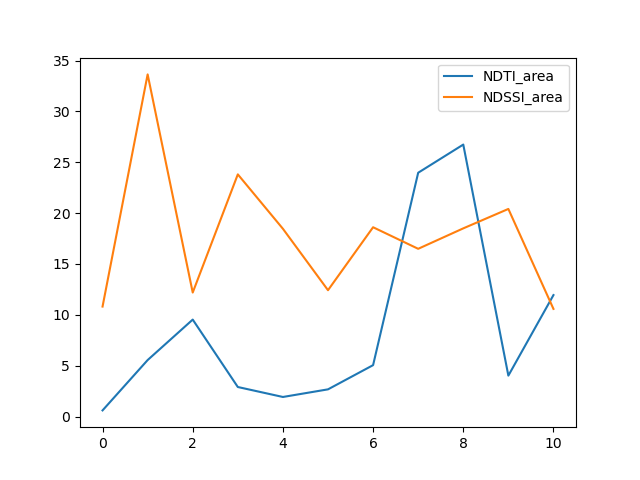

In [32]:
chelan_df.plot()

#yes, this is just a test plot. but the joy it gave me when plotted justifies its inclusion

In [33]:

#chelan_df.date[0]
#datetime = datetime.strptime((i for i in chelan_df.date), '%Y-%m-%d')
chelan_df['datetime'] = chelan_df['date'].astype('datetime64[ns]')
#df['Date'] = df['Date'].astype('datetime64[ns]')
chelan_df

,date,img,NDTI_area,NDSSI_area,datetime
0,2021-03-03,HLS.S30.T10UFU.2021062T190301.v2.0,0.60,10.81,2021-03-03
1,2021-04-02,HLS.S30.T10UFU.2021092T185921.v2.0,5.55,33.64,2021-04-02
2,2021-04-17,HLS.S30.T10UFU.2021107T185909.v2.0,9.53,12.19,2021-04-17
3,2021-05-22,HLS.S30.T10UFU.2021142T185921.v2.0,2.90,23.81,2021-05-22
4,2021-06-01,HLS.S30.T10UFU.2021152T185921.v2.0,1.92,18.46,2021-06-01
5,2021-06-21,HLS.S30.T10UFU.2021172T185921.v2.0,2.67,12.42,2021-06-21
6,2021-06-26,HLS.S30.T10UFU.2021177T185919.v2.0,5.05,18.61,2021-06-26
7,2021-07-06,HLS.S30.T10UFU.2021187T185919.v2.0,23.97,16.49,2021-07-06
8,2021-07-11,HLS.S30.T10UFU.2021192T185921.v2.0,26.74,18.50,2021-07-11
9,2021-07-26,HLS.S30.T10UFU.2021207T185919.v2.0,4.02,20.41,2021-07-26


In [34]:
chelan_df.set_index(chelan_df.datetime, drop=True, inplace=True)
chelan_df

,date,img,NDTI_area,NDSSI_area,datetime
datetime,,,,,
2021-03-03,2021-03-03,HLS.S30.T10UFU.2021062T190301.v2.0,0.60,10.81,2021-03-03
2021-04-02,2021-04-02,HLS.S30.T10UFU.2021092T185921.v2.0,5.55,33.64,2021-04-02
2021-04-17,2021-04-17,HLS.S30.T10UFU.2021107T185909.v2.0,9.53,12.19,2021-04-17
2021-05-22,2021-05-22,HLS.S30.T10UFU.2021142T185921.v2.0,2.90,23.81,2021-05-22
2021-06-01,2021-06-01,HLS.S30.T10UFU.2021152T185921.v2.0,1.92,18.46,2021-06-01
2021-06-21,2021-06-21,HLS.S30.T10UFU.2021172T185921.v2.0,2.67,12.42,2021-06-21
2021-06-26,2021-06-26,HLS.S30.T10UFU.2021177T185919.v2.0,5.05,18.61,2021-06-26
2021-07-06,2021-07-06,HLS.S30.T10UFU.2021187T185919.v2.0,23.97,16.49,2021-07-06
2021-07-11,2021-07-11,HLS.S30.T10UFU.2021192T185921.v2.0,26.74,18.50,2021-07-11


## Final plot for NDTI/NDSSI signal comparison

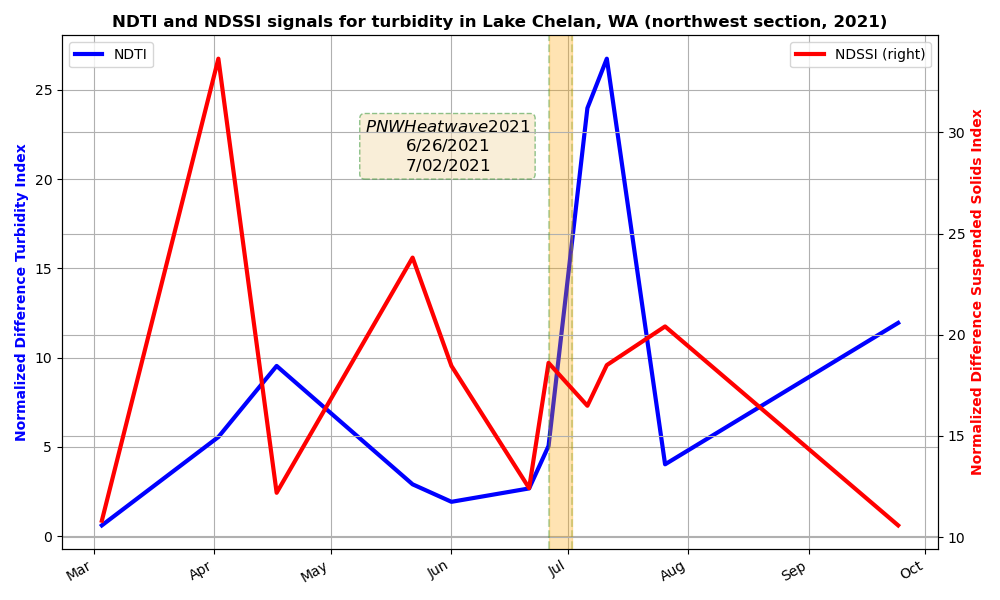

In [35]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')

# ENTER DATES OF EVENT SPAN HERE
start = '6/26/2021'
end = '7/02/2021'
fmt = '%m/%d/%Y'
#start.astype('datetime64[ns]')
start_date = datetime.strptime(start, fmt)
end_date = datetime.strptime(end, fmt)

fig, ax = plt.subplots(figsize=(10,6))

l_NDSSI = 'NDSSI'

ax2 = chelan_df.NDTI_area.plot(color='blue', grid=True, label='NDTI', lw=3)
ax1 = chelan_df.NDSSI_area.plot(color='red', grid=True, secondary_y=True, label=l_NDSSI[0:5], lw=3)

l1 = ax1.axvline(start_date, ls='--', c='forestgreen', alpha=0.3)
l2 = ax2.axvline(end_date, ls='--', c='forestgreen', alpha=0.3)
# Filling between lines
#plt.fill_between(l1, l2, color='grey', alpha='0.5')
plt.axvspan(start_date, end_date, color='orange', alpha=0.3)

textstr = '\n'.join((
    r'$PNW Heatwave 2021$',
    r'$%s$' % (start, ),
    r'$%s$' % (end, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', edgecolor='forestgreen', ls='--', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.44, 0.838, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='center', bbox=props)
#https://matplotlib.org/3.3.4/gallery/recipes/placing_text_boxes.html

ax2.xaxis.set_major_formatter(myFmt)
#df.plot(x=['date'], y=['NDTI_area'])
ax2.set_xlabel('')
ax2.set_ylabel('Normalized Difference Turbidity Index', color='b', fontsize=10, fontweight='bold')
ax1.set_ylabel('Normalized Difference Suspended Solids Index', color='r', fontsize=10, fontweight='bold')
ax2.set_title('NDTI and NDSSI signals for turbidity in Lake Chelan, WA (%s section, %s)' %(window_id, chelan_df.date[0][0:4]), fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.tight_layout()

#save image output
strFile = ('/home/jovyan/project/chelanigans/output/%s/NDTI-NDSSI-signals-timeseries.png' %(notebook))
if os.path.isfile(strFile):
#os.remove(strFile)
    os.system("rm "+strFile)
plt.savefig(strFile);

In [36]:
# # duplicate for attempt to switch NDTI/NDSSI axis and remove "(right)"

# import matplotlib.dates as mdates
# myFmt = mdates.DateFormatter('%b')

# # enter dates of event span here
# start = '6/26/2021'
# end = '7/02/2021'
# fmt = '%m/%d/%Y'
# #start.astype('datetime64[ns]')
# start_date = datetime.strptime(start, fmt)
# end_date = datetime.strptime(end, fmt)

# fig, ax = plt.subplots(figsize=(10,6))

# l_NDSSI = 'NDSSI'

# ax2 = chelan_df.NDSSI_area.plot(color='red', grid=True, secondary_y=True, label=l_NDSSI[0:5], lw=3)
# ax1 = chelan_df.NDTI_area.plot(color='blue', grid=True, label='NDTI', lw=3)

# l1 = ax1.axvline(end_date, ls='--', c='forestgreen', alpha=0.3)
# l2 = ax2.axvline(start_date, ls='--', c='forestgreen', alpha=0.3)

# # Filling between lines
# #plt.fill_between(l1, l2, color='grey', alpha='0.5')
# plt.axvspan(start_date, end_date, color='orange', alpha=0.3)

# textstr = '\n'.join((
#     r'$PNW Heatwave 2021$',
#     r'$%s$' % (start, ),
#     r'$%s$' % (end, )))
# # these are matplotlib.patch.Patch properties
# props = dict(boxstyle='round', facecolor='wheat', edgecolor='forestgreen', ls='--', alpha=0.5)
# # place a text box in upper left in axes coords
# ax.text(0.44, 0.838, textstr, transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', horizontalalignment='center', bbox=props)
# #https://matplotlib.org/3.3.4/gallery/recipes/placing_text_boxes.html

# ax1.xaxis.set_major_formatter(myFmt)
# #df.plot(x=['date'], y=['NDTI_area'])
# ax1.set_xlabel('')
# ax1.set_ylabel('Normalized Difference Turbidity Index', color='b', fontsize=10, fontweight='bold')
# ax2.set_ylabel('Normalized Difference Suspended Solids Index', color='r', fontsize=10, fontweight='bold')
# ax1.set_title('NDTI and NDSSI signals for turbidity in Lake Chelan, WA (%s)' %(chelan_df.date[0][0:4]), fontsize=12, fontweight='bold')
# ax2.legend(loc='upper right')
# ax1.legend(loc='upper left')
# plt.tight_layout()

# #save image output
# strFile = ('/home/jovyan/project/chelanigans/output/%s/NDTI-NDSSI-signals-timeseries.png' %(notebook))
# if os.path.isfile(strFile):
# #os.remove(strFile)
#     os.system("rm "+strFile)
# plt.savefig(strFile);

In [37]:
#this is not accurate for this notebook.
#only the upper ~40% of chelan is analyzed in this notebook.
#use this for chelan_4_raster-area-calcs_whole.ipynb

#chelan_area = chelan_geom.area
#perc = (100 * chelan_df['NDTI_area'] / chelan_area)
#chelan_df['NDTI %'] = (perc)
#perc = (100 * chelan_df['NDSSI_area'] / chelan_area)
#chelan_df['NDSSI %'] = (perc)
#df['Date'] = df['Date'].astype('datetime64[ns]')


###chelan_df.drop(columns=(datetime),  axis=1)
#chelan_df